<a href="https://colab.research.google.com/github/bh8648/DL/blob/main/DL221107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 모델 자체를 활용해서 오버피팅이 일어나지 않게 해보기. (이때까지는 데이터셋을 조정했음)

# 가중치 감쇠 : 가중치가 한쪽에 너무 편향되면 편중된 결과가 나오기 때문에 사용
# 가중치 파라미터 값들이 희소하도록 제한하다 => ?

# 데이터 증강
# 중요 : 데이터의 핵심적인 특징을 유지한 채 노이즈(noise)를 더하여 데이터셋을 확장하는 방법
# 수배에서 수십배의 데이터 확장이 가능
# 노이즈에 더 강인한(robust) 모델을 얻을 수 있음

# 소금과 후추 (salt & pepper) 노이즈 추가

# 드롭아웃 : (a)는 효과가 너무 좋아서 편향값이 너무 높아짐. 따라서 (b)처럼 성능을 제한시켜줌
# 이항분포란? -> 


# (a) At training time 
# p값이 크면 드롭아웃을 더 많이 함.
# (p는 0부터 1 사이의 확률임)
# 1-p는 켜져있는 전등의 확률

# (b) At test time
# 모든 전등을 킨 상태.

# 왜 이렇게 하는가? -> 학습과 추론에 사용되는 노드의 수가 다르기 때문.


# net.train() / net.eval을 호출해서 학습모드를 쓸지 추론모드를 쓸지 타이밍에 맞춰 알아서 전환할 수 있다.




# 배치정규화 (오늘 내용 중 가장 중요함)

# 배치 -> 데이터를 묶음단위로 입력하는 것.


# 왜 배치정규화를 사용하는가? -> 공변량 변화 문제 해결을 위해서.

# 그림의 가장 아래 ???가 의미하는 것. -> 가장 위에서 데이터의 분포를 확인하고 두 번째 줄에서 경사하강법을 사용하여 파라미터를 업데이트(학습) 하는데
# 세 번째를 보면 데이터의 분포가 바뀌기 때문에 ???라고 나옴


# 배치정규화는 파워풀해서 많이들 사용함.

# 배치정규화가 정규화를 잘 해줘서 굳이 드롭아웃을 안해도 됨



In [ ]:
#정규화(Regularization) 구현

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [ ]:
train = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y))+1

print('input_size: %d, output_size: %d' % (input_size, output_size))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [ ]:
# 학습/검증/테스트 데이터셋 구성

# Train / Valid ratio
ratios = [.8, .2]
train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]
print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))
indices = torch.randperm(x.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))
x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [(test.targets)]
for x_i, y_i in zip(x, y) :
  print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [ ]:
# 기본 블록 정의

class Block(nn.Module) :
  def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4) :
    self.input_size = input_size
    self.output_size = output_size
    self.use_batch_norm = use_batch_norm
    self.dropout_p = dropout_p
    super().__init__()
    def get_regularizer(use_batch_norm, size) :
      return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
    self.block = nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.LeakyReLU(),
        get_regularizer(use_batch_norm, output_size)
    )
  def forward(self, x) :
    y = self.block(x)
    return y


In [ ]:
# 모델(신경망) 구성

class MyModel(nn.Module) :
  def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4) :
    super().__init__()
    self.layers = nn.Sequential(
        Block(input_size, 500, use_batch_norm, dropout_p),
        Block(500, 400, use_batch_norm, dropout_p),
        Block(400, 300, use_batch_norm, dropout_p),
        Block(300, 200, use_batch_norm, dropout_p),
        Block(200, 100, use_batch_norm, dropout_p),
        Block(100, 50, use_batch_norm, dropout_p),
        nn.Linear(50, output_size),
        nn.LogSoftmax(dim=-1)
    )
  def forward(self, x) :
    y = self.layers(x)
    return y


# 모델 선언 및 출력
model = MyModel(input_size, output_size, use_batch_norm=True)
print(model)


# 옵티마이저 및 손실함수 설정
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()


MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [ ]:
# GPU 사용 설정
device = torch.device('cpu')
if torch.cuda.is_available() :
  device = torch.device('cuda')

model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]


# 하이퍼 파라미터 및 학습을 위한 변수 설정
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf


In [ ]:
# 학습시작

train_history, valid_history = [], []

for i in range(n_epochs) :
  model.train()

  indices = torch.randperm(x[0].size(0)).to(device)
  x_ = torch.index_select(x[0], dim=0, index=indices)
  y_ = torch.index_select(y[0], dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0,0
  y_hat = []

  for x_i, y_i in zip(x_, y_) :
    y_hat_i = model(x_i)
    loss = crit(y_hat_i, y_i.squeeze())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    train_loss += float(loss)

  train_loss = train_loss / len(x_)


  # 학습시작 : 검증
  model.eval()
  with torch.no_grad() :
    x_ = x[1].split(batch_size, dim=0)
    y_ = y[1].split(batch_size, dim=0)

    valid_loss = 0

    for x_i, y_i in zip(x_, y_) :
      y_hat_i = model(x_i)
      loss = crit(y_hat_i, y_i.squeeze())

      valid_loss += float(loss)

      y_hat += [y_hat_i]
  
  valid_loss = valid_loss / len(x_)

  train_history += [train_loss]
  valid_history += [valid_loss]

  if (i+1) % print_interval == 0:
    print('Epoch %d : train loss=%.4e / valid_loss=%.4e / lowest_loss=%.4e' % (
        i+1,
        train_loss,
        valid_loss,
        lowest_loss
        )
    )

  if valid_loss <= lowest_loss :
    lowest_loss = valid_loss
    lowest_epoch = i

    best_model = deepcopy(model.state_dict())
  
  else :
    if early_stop > 0 and lowest_epoch + early_stop < i+1 :
      print("There is no improvement during last %d epochs." % early_stop)
      break
  

print("The best validation loss from epoch %d : %.4e" % (lowest_epoch+1, lowest_loss))
model.load_state_dict(best_model)


Epoch 10 : train loss=2.3224e-02 / valid_loss=1.0910e-01 / lowest_loss=8.2988e-02
Epoch 20 : train loss=1.2047e-02 / valid_loss=9.2567e-02 / lowest_loss=8.2988e-02
Epoch 30 : train loss=8.9789e-03 / valid_loss=9.5209e-02 / lowest_loss=8.2988e-02
Epoch 40 : train loss=7.7539e-03 / valid_loss=9.0721e-02 / lowest_loss=8.2988e-02
Epoch 50 : train loss=4.5611e-03 / valid_loss=9.8255e-02 / lowest_loss=8.2988e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 6 : 8.2988e-02


<All keys matched successfully>

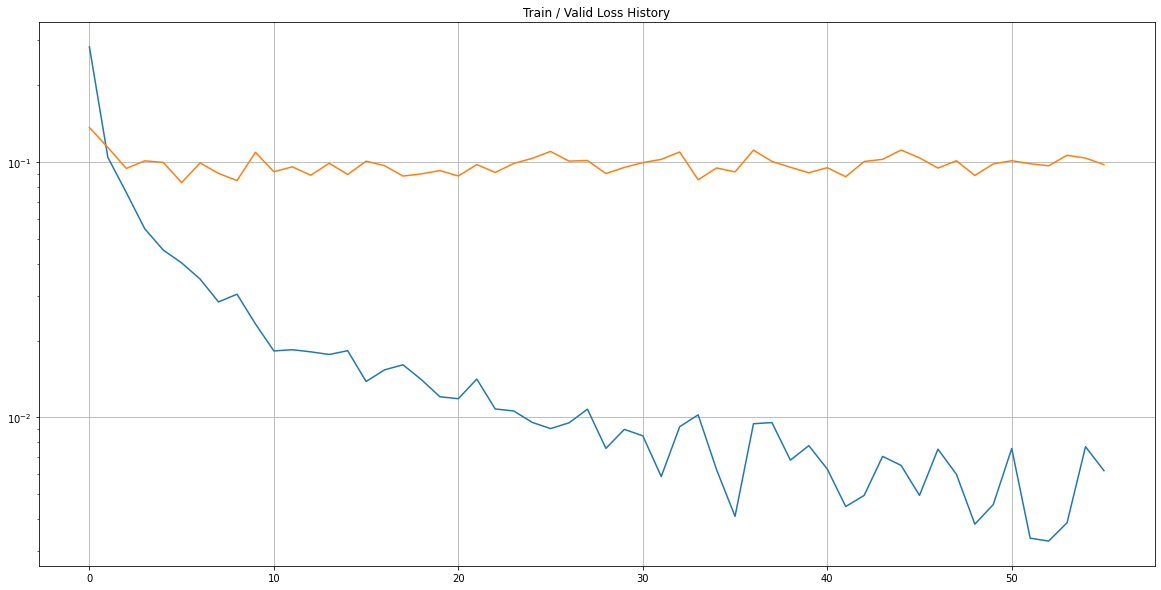

Test Loss : 7.1238e-02
Test Accuracy: 0.9792


In [ ]:
# 손실곡선 확인
plot_from = 0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()


# 테스트
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad() :
  x_ = x[-1].split(batch_size, dim=0)
  y_ = y[-1].split(batch_size, dim=0)

  for x_i, y_i in zip(x_, y_) :
    y_hat_i = model(x_i)
    loss = crit(y_hat_i, y_i.squeeze())

    test_loss += loss

    y_hat += [y_hat_i]

  test_loss = test_loss / len(x_)
  y_hat = torch.cat(y_hat, dim=0)
  print("Test Loss : %.4e" % test_loss)

  correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
  total_cnt = float(y[-1].size(0))

  print("Test Accuracy: %.4f" % (correct_cnt / total_cnt))


In [ ]:
# 혼동행렬
import pandas as pd
from sklearn.metrics import confusion_matrix

print(type(y_hat))
print(type(y))
# print(y) 가장 처음에는 리스트y에 속한 값들이 gpu에 있었음
# y = [i.cpu().numpy() for i in y] 한 번 진행했음
print(y) # 지금은 리스트 y에 속한 값들이 cpu에 있음.
for x in y :
  print(type(x))
  print(x)

pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['True_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

<class 'torch.Tensor'>
<class 'list'>
[array([8, 9, 0, ..., 8, 1, 1]), array([8, 0, 0, ..., 4, 2, 3]), array([7, 2, 1, ..., 4, 5, 6])]
<class 'numpy.ndarray'>
[8 9 0 ... 8 1 1]
<class 'numpy.ndarray'>
[8 0 0 ... 4 2 3]
<class 'numpy.ndarray'>
[7 2 1 ... 4 5 6]


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
True_0,971,0,1,0,0,3,2,2,1,0
True_1,0,1126,2,1,0,0,1,0,5,0
True_2,3,2,1010,3,2,0,1,5,5,1
True_3,0,1,2,987,0,7,0,4,4,5
True_4,0,0,4,0,946,0,1,2,1,28
True_5,1,0,0,6,1,874,2,0,6,2
True_6,2,3,0,1,9,7,933,0,3,0
True_7,0,1,8,2,1,0,0,1003,2,11
True_8,1,0,3,4,2,5,0,2,954,3
True_9,1,2,0,4,7,3,0,1,3,988


In [ ]:
# 문제2는 애초에 학습자료가 배치정규화만을 이용하여 학습하고 테스트 한 것임.
# 드롭아웃을 사용할지 배치정규화를 사용할지는 기본 블록정의의 가장 아래에 적혀있음